## Problem Statement: Predicting Credit Risk for Loan Applicants
### Background: Financial institutions face significant challenges in assessing the creditworthiness of loan applicants. Accurate credit risk prediction is crucial for minimizing defaults and ensuring the stability of the lending system. The German Credit dataset provides a comprehensive set of features related to applicants' financial history, personal information, and loan details, making it an ideal resource for developing predictive models. 
### Objective:Develop a machine learning model to predict the credit risk of loan applicants using the German Credit dataset. The model should classify applicants into two categories: good credit risk and bad credit risk. Additionally, provide insights into the key factors influencing credit risk and suggest strategies for improving the credit evaluation process

In [31]:
import pandas as pd

file_path = "german_credit_data.csv"
df = pd.read_csv(file_path)

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [32]:
#Checking missing values
df.drop(columns=['Unnamed: 0'], inplace=True)
missing_values = df.isnull().sum()
data_info = df.info()
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

### Data Preprocessing: Encoding and scaling

In [46]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df['Saving accounts'].fillna('unknown', inplace=True)
df['Checking account'].fillna('unknown', inplace=True)

categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
df_encoded = df.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save encoders for later interpretation

scaler = StandardScaler()
numerical_cols = ['Age', 'Job','Credit amount', 'Duration']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

df_encoded.head()

C:\Users\neogi\AppData\Local\Temp\ipykernel_7872\2387199464.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Saving accounts'].fillna('unknown', inplace=True)
C:\Users\neogi\AppData\Local\Temp\ipykernel_7872\2387199464.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,2.766456,1,0.146949,1,4,0,-0.745131,-1.236478,5
1,-1.191404,0,0.146949,1,0,1,0.949817,2.248194,5
2,1.183312,1,-1.383771,1,0,3,-0.416562,-0.738668,3
3,0.831502,1,0.146949,0,0,0,1.634247,1.750384,4
4,1.535122,1,0.146949,0,0,0,0.566664,0.256953,1


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df_original = pd.read_csv(file_path)
if 'Risk' in df_original.columns:
    target_col = 'Risk'
    risk_dist = df_original['Risk'].value_counts()
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_original, x='Risk')
    plt.title('Distribution of Credit Risk')
    plt.xlabel('Credit Risk')
    plt.ylabel('Count')
    plt.show()
else:
    target_col = None

target_col

In [48]:
print(df_original.columns)
print(df_original.head())

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose'],
      dtype='object')
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  


In [49]:
credit_threshold = df_encoded['Credit amount'].median()
duration_threshold = df_encoded['Duration'].median()

df_encoded['Risk'] = (
    (df_encoded['Credit amount'] > credit_threshold) &
    (df_encoded['Duration'] < duration_threshold)
).astype(int)

df_encoded['Risk'].value_counts()

Risk
0    901
1     99
Name: count, dtype: int64

#### Model building

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df_encoded.drop(columns=['Risk'])
y = df_encoded['Risk']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[180   0]
 [  0  20]]


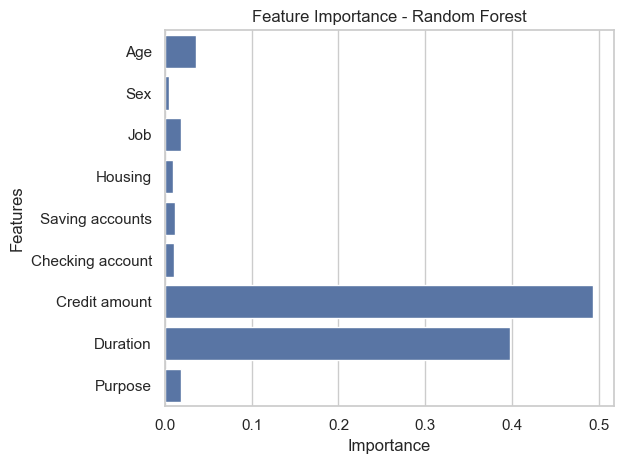

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

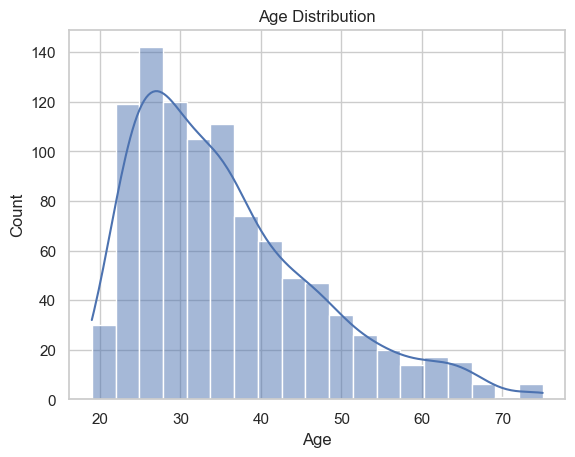

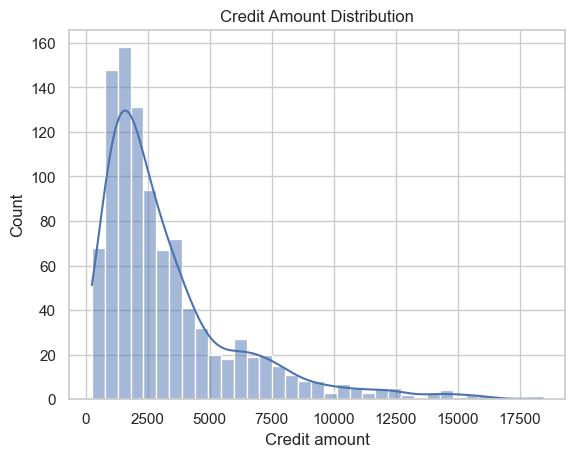

In [53]:
# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Credit amount distribution
sns.histplot(df['Credit amount'], kde=True)
plt.title('Credit Amount Distribution')
plt.show()

